# Team Pizza Plots 

## Packages 

In [1]:
import pandas as pd
import numpy as np
import numpy as np
from datetime import datetime
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.colors as mcolors
from mplsoccer import PyPizza, add_image, FontManager
import matplotlib as mpl
import pickle
from PIL import Image
import urllib

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Useful Mappings 

In [3]:
home_colors = {
    'Arsenal': '#E63636',
    'Aston Villa' : '#811331',
    'Brentford' : '#E63636', 
    'Bournemouth' : '#E63636',
    'Brighton': '#2d8ce7',
    'Chelsea' : '#2D5DE7',
    'Crystal Palace' : '#E63636',
    'Everton' : '#2D5DE7', 
    'Fulham' : '#9C9C9C', 
    'Leeds' : '#9C9C9C', 
    'Leicester' : '#2d8ce7',
    'Liverpool' : '#E63636',
    'Nottingham Forest' : '#E63636',
    'Newcastle' : '#9C9C9C',
    'Man Utd' : '#E63636',
    'Man City' : '#6FC6E6',
    'Southampton' : '#E63636',
    'Tottenham' : '#9C9C9C', 
    'West Ham' : '#811331',
    'Wolves' : '#DA9D0A'
}


logos = {
    'Arsenal': 9825,
    'Aston Villa' : 10252,
    'Brentford' : 9937, 
    'Bournemouth' : 8678, 
    'Brighton': 10204,
    'Chelsea' : 8455,
    'Crystal Palace' : 9826, 
    'Everton' : 8668, 
    'Fulham' : 9879, 
    'Leeds' : 8463, 
    'Leicester' : 8197,
    'Liverpool' : 8650,
    'Nottingham Forest' : 10203,
    'Newcastle' : 10261,
    'Man Utd' : 10260,
    'Man City' : 8456,
    'Southampton' : 8466,
    'Tottenham' : 8586, 
    'West Ham' : 8654,
    'Wolves' : 8602
}


mapping = {
    'Arsenal': 13,
    'Aston Villa' : 24,
    'Brentford' : 189, 
    'Bournemouth' : 183,
    'Brighton': 211,
    'Chelsea' : 15,
    'Crystal Palace' : 162,
    'Everton' : 31, 
    'Fulham' : 170, 
    'Leeds' : 19, 
    'Leicester' : 14,
    'Liverpool' : 26,
    'Nottingham Forest' : 174,
    'Newcastle' : 23,
    'Man Utd' : 32,
    'Man City' : 167,
    'Southampton' : 18,
    'Tottenham' : 30, 
    'West Ham' : 29,
    'Wolves' : 161, 
}

## Read Data 
- Read data that contains events data for PL 22-23 season

In [4]:
df1 = pd.read_csv('pl_2223_FirstHalf.csv').iloc[:,1:]
df2 = pd.read_csv('pl_2223_SecondHalf.csv').iloc[:,1:]

## Functions
- These functions will calculate the key metrics that we'll be ranking teams based on/producing pizza/percentile plots

### xG/xGA
- Non-Penalty xG For and Against

In [5]:
# Info needed for function/our xg model

pitch_length_x = 100
pitch_length_y = 100

feature_cols = ['id',
                'teamId',
                'prevTeam',
                'x', 
                'y',
                'playerName', 
                'playerAssist',
                'minute', 
                'second',
                'type',
                'prevEvent',
                'isGoal',
                'shotRightFoot',
                'shotLeftFoot',
                'shotHead',
                'shotOpenPlay',
                'shotSetPiece',
                'shotCounter', 
                'penaltyScored',
                'penaltyMissed',
                'goalOwn',
                'bigChanceMissed',
                'bigChanceScored',
              ]

shot_types = ['SavedShot', 
              'MissedShots', 
              'Goal', 
              'ShotOnPost'
             ]

In [6]:
def NPXG_CALC(df, mainID, oppID):
    df["passRecipient"] = df['playerName'].shift(-1)
    df['teamRecipient'] = df['teamId'].shift(-1)
    df['prevEvent'] = df['type'].shift(1)
    df['shotLongPass'] = df['keyPassLong'].shift(1)
    df['shotShortPass'] = df['keyPassShort'].shift(1)
    df['shotCross'] = df['keyPassCross'].shift(1)
    df['shotThroughBall'] = df['keyPassThroughball'].shift(1)
    df['playerAssist'] = df['playerName'].shift(1)
    df['prevTeam'] = df['teamId'].shift(1)

    column_to_move = df.pop("passRecipient")
    df.insert(29, "passRecipient", column_to_move)
    column_to_move = df.pop("teamRecipient")
    df.insert(27, "teamRecipient", column_to_move)
    column_to_move = df.pop('prevEvent')
    df.insert(11, "prevEvent", column_to_move)

    df_shots = df[df['type'].isin(shot_types)].reset_index(drop=True)[feature_cols]

    df_shots = df_shots[(df_shots['penaltyScored'] == False) & 
                        (df_shots['penaltyMissed'] == False) &
                        (df_shots['goalOwn'] == False)
                       ]

    df_shots['distance_to_goal'] = np.sqrt(((pitch_length_x - df_shots['x'])**2 + 
                                    (pitch_length_y - df_shots['y'])**2))
    df_shots['distance_to_center'] = abs(df_shots['y'] - pitch_length_y/2)
    df_shots['angle'] = np.absolute(np.degrees(np.arctan((abs((pitch_length_y/2) - df_shots['y'])) 
                                                         / (pitch_length_x - df_shots['x']))))


    df_shots = df_shots.drop(['prevEvent', 'penaltyScored', 'penaltyMissed', 'goalOwn', 'type'], axis=1)
    
    # Add Big Chance Column
    df_shots['bigChance'] = df_shots['bigChanceMissed'] | df_shots['bigChanceScored']
    df_shots = df_shots.drop(['bigChanceMissed', 'bigChanceScored'], axis=1)

    cat_cols = ['shotRightFoot',
            'shotLeftFoot',
            'shotHead',
            'shotOpenPlay',
            'shotSetPiece',
            'shotCounter',
            'bigChance'
           ]
    df_shots[cat_cols] *= 1
    
    df_shots = df_shots.reset_index(drop=True)
    
    X_game = df_shots.iloc[:, 10:]
    Y_game = df_shots['isGoal']
    
    # Import our xG model 
    xg_model = pickle.load(open('xgModel_XGBoost22.sav', 'rb'))
    
    
    y_pred_game = xg_model.predict_proba(X_game)
    df_pred_game = pd.DataFrame(y_pred_game, columns = ['prob_no_goal', 'prob_goal'])
    df_pred_game = pd.merge(df_shots, df_pred_game, left_index=True, right_index=True).reset_index(drop=True)
    
    # For Home Team
    home_opxg = df_pred_game[(df_pred_game['teamId'] == mainID) &
                             ((df_pred_game['shotOpenPlay'] == 1) | (df_pred_game['shotCounter'] == 1)) & 
                             (df_pred_game['shotSetPiece'] == 0)].reset_index(drop=True)['prob_goal'].sum()

    home_spxg = df_pred_game[(df_pred_game['teamId'] == mainID) &
                             (df_pred_game['shotOpenPlay'] == 0) & 
                             (df_pred_game['shotSetPiece'] == 1)].reset_index(drop=True)['prob_goal'].sum()

    # For Away Team
    away_opxg = df_pred_game[(df_pred_game['teamId'] == oppID) &
                            ((df_pred_game['shotOpenPlay'] == 1) | (df_pred_game['shotCounter'] == 1)) & 
                             (df_pred_game['shotSetPiece'] == 0)].reset_index(drop=True)['prob_goal'].sum()

    away_spxg = df_pred_game[(df_pred_game['teamId'] == oppID) &
                             (df_pred_game['shotOpenPlay'] == 0) & 
                             (df_pred_game['shotSetPiece'] == 1)].reset_index(drop=True)['prob_goal'].sum()
    
    
    return home_opxg, home_spxg, away_opxg, away_spxg

### xT via Pass + Carry  

In [7]:
def XT_PASS(events_df, ID):
    zones = []
    for i in range(8):
        row = []
        for j in range(12):
            zone = i + ((j)*8)
            row.append(zone)
        zones.append(row)
    zones = np.array(zones)
    
    xT_list = []
    path = "https://karun.in/blog/data/open_xt_12x8_v1.json"
    xT = pd.read_json(path)
    xT = np.array(xT).T
    xT_rows, xT_cols = xT.shape

    x_bins = np.array(np.linspace(0,100, 13), dtype=object)
    y_bins = np.array(np.linspace(0, 100, 9), dtype=object)
    
    df_passes = events_df[(events_df['type'] == 'Pass') & 
                          (events_df['outcomeType'] == 'Successful') & 
                          (events_df['teamId'] == ID)].reset_index(drop=True)


    df_passes['x1_bin'] = pd.cut(df_passes['x'], bins=x_bins, labels=False, include_lowest=True)
    df_passes['x2_bin'] = pd.cut(df_passes['endX'], bins=x_bins, labels=False, include_lowest=True)
    df_passes['y1_bin'] = pd.cut(df_passes['y'], bins=y_bins, labels=False, include_lowest=True)
    df_passes['y2_bin'] = pd.cut(df_passes['endY'], bins=y_bins, labels=False, include_lowest=True)
    df_passes['xT_start'] = df_passes[['x1_bin', 'y1_bin']].apply(lambda x:xT[x[0]][x[1]], axis=1)
    df_passes['xT_end'] = df_passes[['x2_bin', 'y2_bin']].apply(lambda x:xT[x[0]][x[1]], axis=1)
    df_passes['xT_diff'] = df_passes['xT_end'] - df_passes['xT_start']
    df_passes['zone'] = df_passes[['x1_bin', 'y2_bin']].apply(lambda x:zones[x[1]][x[0]], axis=1)
    df_passes = df_passes[df_passes['xT_diff'] > 0].reset_index(drop=True)
    df_passes = df_passes[['x', 'y', 'x1_bin', 'y1_bin', 'zone', 'xT_diff']]
    
    xt_pass = df_passes['xT_diff'].sum()

    return xt_pass


def XT_CARRY(events_df, ID):
    zones = []
    for i in range(8):
        row = []
        for j in range(12):
            zone = i + ((j)*8)
            row.append(zone)
        zones.append(row)
    zones = np.array(zones)
    
    xT_list = []
    path = "https://karun.in/blog/data/open_xt_12x8_v1.json"
    xT = pd.read_json(path)
    xT = np.array(xT).T
    xT_rows, xT_cols = xT.shape

    x_bins = np.array(np.linspace(0,100, 13), dtype=object)
    y_bins = np.array(np.linspace(0, 100, 9), dtype=object)
    
    df_carries = pd.DataFrame()
    min_len = 3
    max_len = 60
    min_time = 1
    max_time = 12

    for idx, match_event in events_df.iterrows():
        if idx == len(events_df) - 1:
            break

        cur_team = match_event['teamId']
        idx_next = idx + 1
        events_df_next = events_df.loc[idx_next]
        take_ons = 0
        loop = True
        count = 0 

        while loop:
            next_events = events_df.loc[idx_next]

            if next_events['type'] == 'TakeOn' and next_events['outcomeType'] == 'Successful':
                take_ons += 1
                loop = True

            elif (next_events['type'] == 'TakeOn' and next_events['outcomeType'] == 'Unsuccessful') or (next_events['teamId'] != cur_team and next_events['type'] == 'Challenge' and next_events['outcomeType'] == 'Unsuccessful') or (next_events['type'] == 'Foul'):
                loop = True

            else:
                loop = False

            idx_next += 1
            count += 0 


        same_team = cur_team == next_events['teamId']
        not_ball_touch = match_event['type'] != 'BallTouch'
        dx = 105 * (match_event['endX'] - next_events['x'])/100
        dy = 68 * (match_event['endY'] - next_events['y'])/100
        min_dist = dx**2 + dy**2 >= min_len**2
        max_dist = dx**2 + dy**2 <= max_len**2
        same_period = match_event['period'] == next_events['period']

        valid_carry = same_team & not_ball_touch & min_dist & max_dist & same_period 

        if valid_carry:
            carry = pd.DataFrame()
            prev = match_event
            nxt = next_events
            carry.loc[0, 'eventId'] = prev['eventId'] + count
            carry['id'] = prev['id'] + count
            carry['teamId'] = nxt['teamId']
            carry['x'] = prev['endX']
            carry['y'] = prev['endY']
            carry['period'] = nxt['period']
            carry['type'] = carry.apply(lambda x: {'value': 99, 'displayName': 'Carry'}, axis=1)
            carry['outcomeType'] = 'Successful'
            carry['qualifiers'] = carry.apply(
                lambda x: {'type': {'value': 999, 'displayName': 'takeOns'}, 'value': str(take_ons)}, axis=1)
            carry['satisfiedEventsTypes'] = carry.apply(lambda x: [], axis=1)
            carry['isTouch'] = True
            carry['playerId'] = nxt['playerId']
            carry['playerName'] = nxt['playerName']
            carry['endX'] = nxt['x']
            carry['endY'] = nxt['y']

            df_carries = pd.concat([df_carries, carry], ignore_index=True, sort=False)
            
    df_carries1 = df_carries[df_carries['teamId'] == ID]
    df_carries1['x1_bin'] = pd.cut(df_carries1['x'], bins=x_bins, labels=False, include_lowest=True)
    df_carries1['x2_bin'] = pd.cut(df_carries1['endX'], bins=x_bins, labels=False, include_lowest=True)
    df_carries1['y1_bin'] = pd.cut(df_carries1['y'], bins=y_bins, labels=False, include_lowest=True)
    df_carries1['y2_bin'] = pd.cut(df_carries1['endY'], bins=y_bins, labels=False, include_lowest=True)
    df_carries1['xT_start'] = df_carries1[['x1_bin', 'y1_bin']].apply(lambda x:xT[x[0]][x[1]], axis=1)
    df_carries1['xT_end'] = df_carries1[['x2_bin', 'y2_bin']].apply(lambda x:xT[x[0]][x[1]], axis=1)
    df_carries1['xT_diff'] = df_carries1['xT_end'] - df_carries1['xT_start']
    df_carries1['zone'] = df_carries1[['x1_bin', 'y2_bin']].apply(lambda x:zones[x[1]][x[0]], axis=1)
    df_carries1 = df_carries1[df_carries1['xT_diff'] > 0].reset_index(drop=True)
    df_carries1 = df_carries1[['x', 'y', 'x1_bin', 'y1_bin', 'zone', 'xT_diff']]

    xt_carry = df_carries1['xT_diff'].sum()


    return xt_carry

### Box Shots  

In [8]:
def BOX_SHOTS(df, ID):
    df["passRecipient"] = df['playerName'].shift(-1)
    df['teamRecipient'] = df['teamId'].shift(-1)
    df['prevEvent'] = df['type'].shift(1)
    df['shotLongPass'] = df['keyPassLong'].shift(1)
    df['shotShortPass'] = df['keyPassShort'].shift(1)
    df['shotCross'] = df['keyPassCross'].shift(1)
    df['shotThroughBall'] = df['keyPassThroughball'].shift(1)
    df['playerAssist'] = df['playerName'].shift(1)
    df['prevTeam'] = df['teamId'].shift(1)

    column_to_move = df.pop("passRecipient")
    df.insert(29, "passRecipient", column_to_move)
    column_to_move = df.pop("teamRecipient")
    df.insert(27, "teamRecipient", column_to_move)
    column_to_move = df.pop('prevEvent')
    df.insert(11, "prevEvent", column_to_move)

    df_shots = df[df['type'].isin(shot_types)].reset_index(drop=True)[feature_cols]

    df_shots = df_shots[(df_shots['penaltyScored'] == False) & 
                        (df_shots['penaltyMissed'] == False) &
                        (df_shots['goalOwn'] == False)
                       ]

    df_shots['distance_to_goal'] = np.sqrt(((pitch_length_x - df_shots['x'])**2 + 
                                    (pitch_length_y - df_shots['y'])**2))
    df_shots['distance_to_center'] = abs(df_shots['y'] - pitch_length_y/2)
    df_shots['angle'] = np.absolute(np.degrees(np.arctan((abs((pitch_length_y/2) - df_shots['y'])) 
                                                         / (pitch_length_x - df_shots['x']))))


    df_shots = df_shots.drop(['prevEvent', 'penaltyScored', 'penaltyMissed', 'goalOwn', 'type'], axis=1)
    
    # Add Big Chance Column
    df_shots['bigChance'] = df_shots['bigChanceMissed'] | df_shots['bigChanceScored']
    df_shots = df_shots.drop(['bigChanceMissed', 'bigChanceScored'], axis=1)

    cat_cols = ['shotRightFoot',
            'shotLeftFoot',
            'shotHead',
            'shotOpenPlay',
            'shotSetPiece',
            'shotCounter',
            'bigChance'
           ]
    df_shots[cat_cols] *= 1
    
    X_game = df_shots.iloc[:, 10:]
    Y_game = df_shots['isGoal']
    
    # Import our xG model 
    xg_model = pickle.load(open('xgModel_XGBoost22.sav', 'rb'))
    
    
    y_pred_game = xg_model.predict_proba(X_game)
    df_pred_game = pd.DataFrame(y_pred_game, columns = ['prob_no_goal', 'prob_goal'])
    df_pred_game = pd.merge(df_shots, df_pred_game, left_index=True, right_index=True).reset_index(drop=True)

    boxshots = len(df_pred_game[(df_pred_game['teamId'] == ID) & 
                  (df_pred_game['x'] >= 83) & 
                  (df_pred_game['y'] >= 21.1) & 
                  (df_pred_game['y'] <= 78.9)].reset_index(drop=True)) 

    return boxshots
 

### Box Touches  

In [9]:
def BOX_TOUCHES(events_df, ID):
    box_touches = len(events_df[(events_df['teamId'] == ID) &
                                (events_df['isTouch'] == True) &
                                (events_df['x'] >= 83) &
                                (events_df['y'] >= 21.1) & 
                                (events_df['y'] <= 78.9)])
    
    return box_touches

### Defensive Action Height

In [10]:
def DEF_ACTION_HEIGHT(events_df, main_id):
    defensive_actions = events_df[(events_df['type'].isin(['Tackle', 'Interception', 'BlockedPass', 'Foul'])) &
                                  (events_df['teamId'] == main_id)].reset_index(drop=True)
    
    avg_action = defensive_actions['x'].mean()
    
    avg_action *= 1.05

    return avg_action

### Field Tilt

In [11]:
def FIELD_TILT(events_df, mainID, oppID):    
    main_ft_val = len(events_df[(events_df['teamId'] == mainID) &
                                (events_df['type'] == 'Pass') & 
                                (events_df['x'] > 66.6) & 
                                (events_df['endX'] > 66.6)].reset_index(drop=True))

    opp_ft_val = len(events_df[(events_df['teamId'] == oppID) &
                                (events_df['type'] == 'Pass') &                           
                                (events_df['x'] > 66.6) & 
                                (events_df['endX'] > 66.6)].reset_index(drop=True))

    den = main_ft_val + opp_ft_val
    main_ft, opp_ft = (main_ft_val/den, opp_ft_val/den)
    
    return main_ft

### Avg Pass Seq Len

In [12]:
def AVG_SEQ_LEN(events_df, main_id):
    seq_list = []
    seq = 0
    count = 0
    flag = False

    for i in range(len(events_df)):
        if (events_df['teamId'][i] == main_id):
            if (events_df['type'][i] == 'Pass') and (events_df['outcomeType'][i] == 'Successful'):
                count += 1

            if count >= 10 and flag == False:
                seq += 1
                flag = True


        else:
            seq_list.append(count)
            count = 0
            flag = False

    avg_seq = round(np.mean([x for x in seq_list if x > 0]),2)
    
    return avg_seq


### Completed Passes 

In [13]:
def COMP_PASSES(events_df, main_id):
    passes = len(events_df[(events_df['teamId'] == main_id) & 
                       (events_df['type'] == 'Pass') &
                       (events_df['outcomeType'] == 'Successful')])
    
    return passes

### PPDA

In [14]:
def PPDA(events_df, main_id, opp_id):
    passes = len(events_df[(events_df['teamId'] == opp_id) & 
                           (events_df['type'] == 'Pass') &
                           (events_df['outcomeType'] == 'Successful') & 
                           (events_df['x'] <= 60)])
    
    defensive_actions = len(events_df[(events_df['teamId'] == main_id) & 
                                      (events_df['type'].isin(['Tackle', 'Challenge', 'Interception', 
                                                               'Foul',])) & 
                                      (events_df['x'] >= 40)])
    
    home_ppda = round(passes/defensive_actions,2)
    
    return home_ppda

### Opp Buildup %

In [15]:
def OPP_BUILDUP(events_df, opp_id):
    total_passes = len(events_df[(events_df['teamId'] == opp_id) & 
                                 (events_df['type'] == 'Pass') &
                                 (events_df['x'] <= 60)])

    passes = len(events_df[(events_df['teamId'] == opp_id) & 
                           (events_df['type'] == 'Pass') &
                           (events_df['outcomeType'] == 'Successful') & 
                           (events_df['x'] <= 60)])
    
    opp_buildup = round(passes/total_passes, 4)
    
    return opp_buildup

### High Possession Regains  

In [16]:
def HIGH_POSS_REGAINS(df, teamID):
    pitch_length_x = 105
    pitch_length_y = 34
    
    df['x_m'] = df['x'] * 1.05
    df['y_m'] = df['y'] * 0.68
    
    df['distance_to_goal'] = np.sqrt(((pitch_length_x - df['x'])**2 + 
                                      (pitch_length_y - df['y'])**2))
    df['teamRecipient'] = df['teamId'].shift(-1)

    hpr = df[(df['distance_to_goal'] <= 45) & 
             (df['type'].isin(['Tackle', 'Interception', 'Challenge', 'BallRecovery', 'BlockedPass'])) &
             (df['outcomeType'] == 'Successful') & 
             (df['teamId'] == teamID) & 
             (df['teamRecipient'] == teamID)]
    
    return len(hpr)

## Loop over all teams and calculate 

In [17]:
overall_metrics = {
    'npxg_created_op' : defaultdict(list),
    'npxg_created_sp' : defaultdict(list), 
    'npxg_allowed_op' : defaultdict(list),
    'npxg_allowed_sp' : defaultdict(list), 
    'xt_created' : defaultdict(list), 
    'xt_allowed' : defaultdict(list), 
    'box_shots' : defaultdict(list), 
    'box_shots_conceded' : defaultdict(list), 
    'box_touches' : defaultdict(list), 
    'def_action_height' : defaultdict(list), 
    'def_action_height' : defaultdict(list), 
    'field_tilt' : defaultdict(list), 
    'avg_seq_len' : defaultdict(list), 
    'comp_passes' : defaultdict(list), 
    'ppda' : defaultdict(list), 
    'opp_buildup' : defaultdict(list), 
    'high_pressure_regains' : defaultdict(list)   
}


for name, teamID in mapping.items():
    
    metrics = {
        'npxg_created_op' : [],
        'npxg_created_sp' : [], 
        'npxg_allowed_op' : [],
        'npxg_allowed_sp' : [], 
        'xt_created' : [], 
        'xt_allowed' : [], 
        'box_shots' : [], 
        'box_shots_conceded' : [], 
        'box_touches' : [], 
        'def_action_height' : [], 
        'def_action_height' : [], 
        'field_tilt' : [], 
        'avg_seq_len' : [], 
        'comp_passes' : [], 
        'ppda' : [], 
        'opp_buildup' : [], 
        'high_pressure_regains' : []   
    }

        
    matches1 = df1[df1['teamId'] == teamID]['matchId'].unique()
    df = df1[df1['matchId'].isin(matches1)].reset_index(drop=True)
    
    for match in matches1:
        df_game = df[df['matchId'] == match].reset_index(drop=True)
        
        ids = df_game['teamId'].unique()
        oppID = [id_ for id_ in ids if id_ != teamID][0]
        
        vals1 = [a for a in NPXG_CALC(df_game, teamID, oppID)]
        
        vals2 = [
                    XT_PASS(df_game, teamID) + XT_CARRY(df_game, teamID), 
                    XT_PASS(df_game, oppID) + XT_CARRY(df_game, oppID),
                    BOX_SHOTS(df_game, teamID),
                    BOX_SHOTS(df_game, oppID),
                    BOX_TOUCHES(df_game, teamID),
                    DEF_ACTION_HEIGHT(df_game, teamID),
                    FIELD_TILT(df_game, teamID, oppID),
                    AVG_SEQ_LEN(df_game, teamID),
                    COMP_PASSES(df_game, teamID),
                    PPDA(df_game, teamID, oppID),
                    OPP_BUILDUP(df_game, oppID),
                    HIGH_POSS_REGAINS(df_game, teamID)
               ]
         
        vals = vals1 + vals2
        
        i = 0
        for key, _ in metrics.items():
            val = vals[i]
            metrics[key].append(val)
            i += 1
            
            
    matches2 = df2[df2['teamId'] == teamID]['matchId'].unique()
    df = df2[df2['matchId'].isin(matches2)].reset_index(drop=True)
    
    for match in matches2:
        df_game = df[df['matchId'] == match].reset_index(drop=True)
        
        ids = df_game['teamId'].unique()
        oppID = [id_ for id_ in ids if id_ != teamID][0]
        
        vals1 = [a for a in NPXG_CALC(df_game, teamID, oppID)]
        
        vals2 = [
                    XT_PASS(df_game, teamID) + XT_CARRY(df_game, teamID), 
                    XT_PASS(df_game, oppID) + XT_CARRY(df_game, oppID),
                    BOX_SHOTS(df_game, teamID),
                    BOX_SHOTS(df_game, oppID),
                    BOX_TOUCHES(df_game, teamID),
                    DEF_ACTION_HEIGHT(df_game, teamID),
                    FIELD_TILT(df_game, teamID, oppID),
                    AVG_SEQ_LEN(df_game, teamID),
                    COMP_PASSES(df_game, teamID),
                    PPDA(df_game, teamID, oppID),
                    OPP_BUILDUP(df_game, oppID),
                    HIGH_POSS_REGAINS(df_game, teamID)
               ]
         
        vals = vals1 + vals2
        
        i = 0
        for key, _ in metrics.items():
            val = vals[i]
            metrics[key].append(val)
            i += 1
            
    for key, val in metrics.items():
        avg_val = sum(val)/len(val)
        overall_metrics[key][name] = avg_val

In [18]:
percentile_metrics = {
    'npxg_created_op' : defaultdict(list),
    'npxg_created_sp' : defaultdict(list), 
    'npxg_allowed_op' : defaultdict(list),
    'npxg_allowed_sp' : defaultdict(list), 
    'xt_created' : defaultdict(list), 
    'xt_allowed' : defaultdict(list), 
    'box_shots' : defaultdict(list), 
    'box_shots_conceded' : defaultdict(list), 
    'box_touches' : defaultdict(list), 
    'def_action_height' : defaultdict(list), 
    'field_tilt' : defaultdict(list), 
    'avg_seq_len' : defaultdict(list), 
    'comp_passes' : defaultdict(list), 
    'ppda' : defaultdict(list), 
    'opp_buildup' : defaultdict(list), 
    'high_pressure_regains' : defaultdict(list)   
}

for metric, mapping in overall_metrics.items():
    vals = list(mapping.values())
    
    for team, val in mapping.items():
        rank = len([score for score in vals if score < val])/19
        percentile_metrics[metric][team] = rank

## For Individual Team

In [19]:
name = 'Chelsea'

In [20]:
team_metrics = defaultdict(float)
for metric, mapping in percentile_metrics.items():
    team_metrics[metric] = percentile_metrics[metric][name]
    
team_act_metrics = defaultdict(float)
for key, mapping in overall_metrics.items():
    team_val = mapping[name]
    team_act_metrics[key] = team_val

In [21]:
df = pd.DataFrame()

for metric, val in team_metrics.items():
    df.loc[0, metric] = val
    
for metric, val in team_act_metrics.items():
    if metric == 'field_tilt' or metric == 'opp_buildup':
        val *= 100
    df.loc[1, metric] = val

In [22]:
df = df[
        ['npxg_created_op', 'npxg_created_sp', 
         'xt_created' ,
         'box_shots', 'box_touches', 
         'npxg_allowed_op', 'npxg_allowed_sp', 
         'xt_allowed', 
         'box_shots_conceded' , 
         'comp_passes', 'avg_seq_len', 'field_tilt' , 
         'ppda', 'opp_buildup', 'high_pressure_regains', 'def_action_height']
]


reverse_cols = ['npxg_allowed_op', 'npxg_allowed_sp', 'xt_allowed', 'box_shots_conceded', 
                'ppda', 'opp_buildup']
for col in df:
    if col in reverse_cols:
        df.loc[0, col] = 1 - df.loc[0, col]

        
df.columns = ['NPXG Created -\nOpen Play\n', 'NPXG Created -\nSet Piece\n', 
              'XT Created', 
              'Box Shots\n', 'Box Touches\n', 
              '\nNPXG Conceded -\nOpen Play', '\nNPXG Conceded -\nSet Piece', 
              'XT Conceded', 
              '\nBox Shots\nConceded', 
              '\nCompleted\nPasses', '\nAverage Seq\nLength', '\nField Tilt',
              '\nPPDA', 'Opp Buildup %\n', 'High Regains\n', 'Def Action\nHeight\n']

## Plot 

In [23]:
fields = df.columns.values.tolist()
fields = [field.upper() for field in fields]
values = df.loc[0, :].values.flatten().tolist()
values = [round(val*100,2) for val in values]

values2 = df.loc[1, :].values.flatten().tolist()
values2 = [round(val,2) for val in values2]

In [24]:
blank_colors = ["#848484"] * 16
slice_colors = ["#1A78CF"] * 5 + ["#D70232"] * 4 + ["#228B22"] * 3 +  ['#FF8000'] * 4 
text_colors = ["#000000"] * 16

In [25]:
# Color Map
def colorFader(c1,c2,mix=0): 
    c1=np.array(mcolors.to_rgb(c1))
    c2=np.array(mcolors.to_rgb(c2))
    
    mix = max(0.35, mix)
    
    return mcolors.to_hex((mix)*c1 + (1-mix)*c2)

slice_colors2 = []
alt_color = '#2B2B2B'
for i, color in enumerate(slice_colors):
    pct = values[i]
    
    slice_colors2.append(colorFader(color, '#2B2B2B', pct/100))

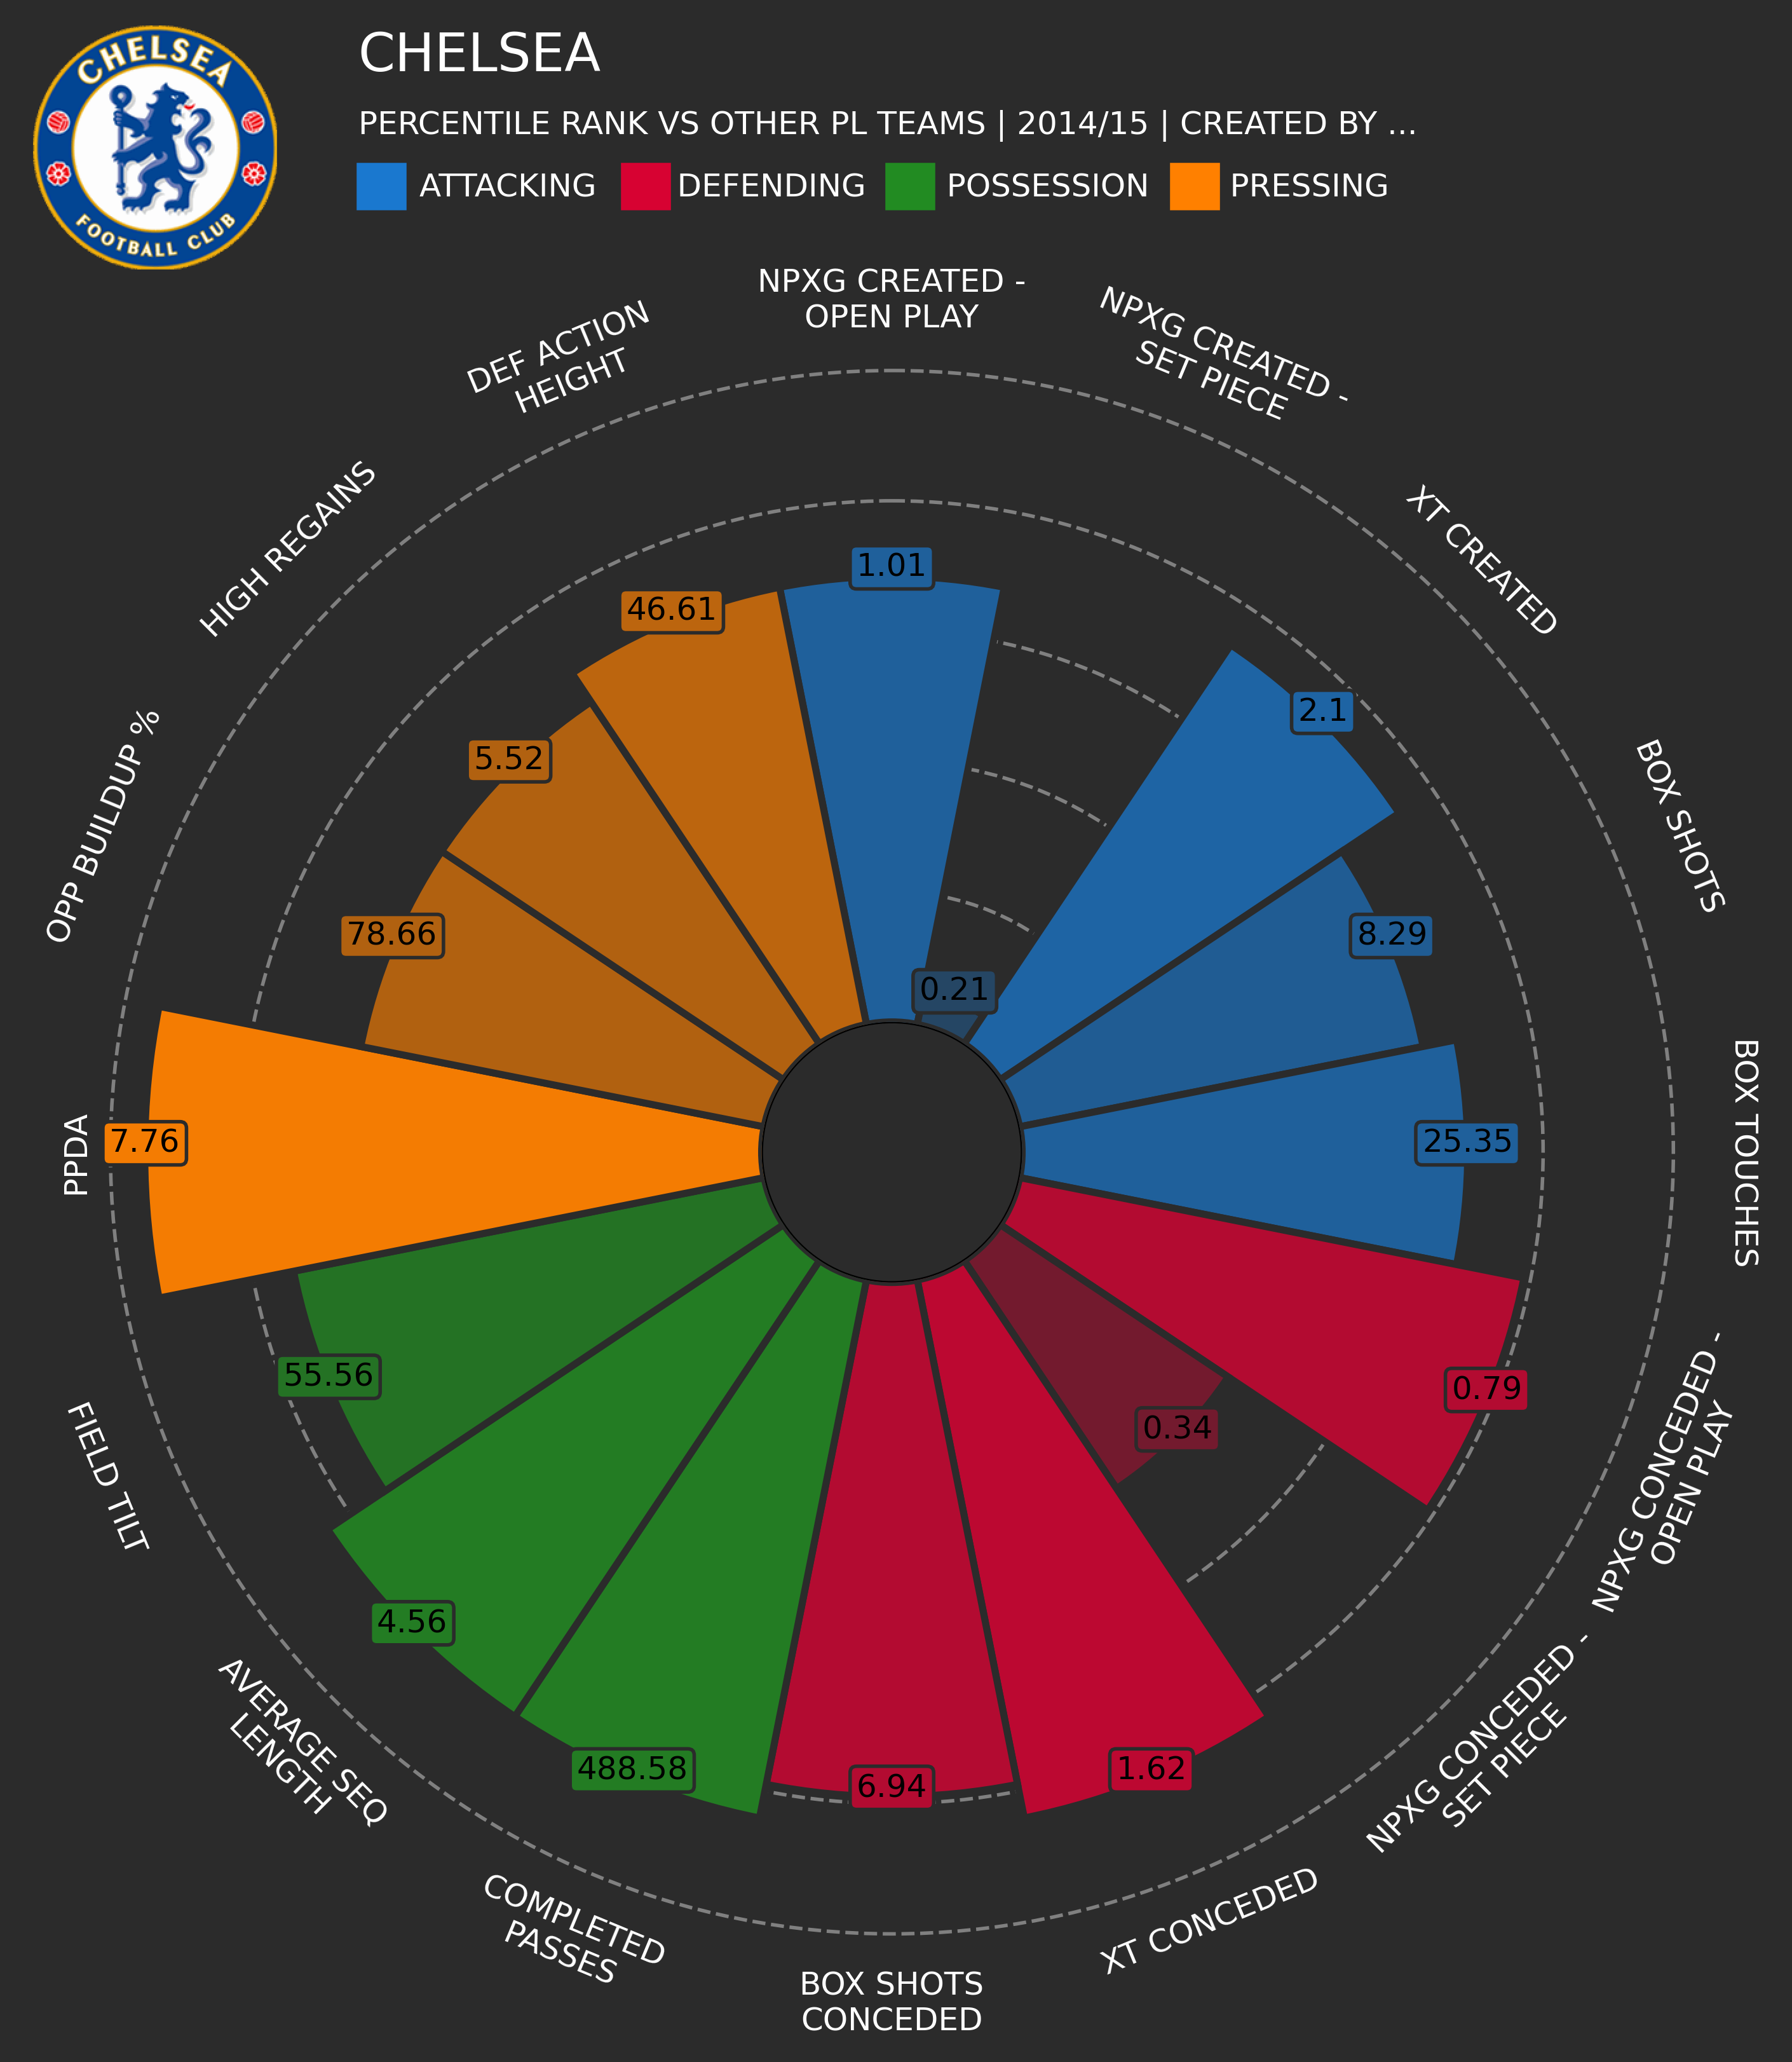

In [27]:
mpl.rcParams['figure.dpi'] = 400

plot = PyPizza(
    inner_circle_size = 20,
    params=fields,                  # list of parameters
    straight_line_color="#2B2B2B",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls= '--'  ,        # linestyle for other circles
    last_circle_lw=1,               # linewidth of last circle
    last_circle_ls = '-',
    background_color = '#2B2B2B',
    straight_line_limit = 101
)

fig, ax = plot.make_pizza(
    values,                             # list of values
    figsize=(8, 9),                     # adjust the figsize according to your need
    slice_colors=slice_colors2,          # color for individual slices
    value_colors=text_colors,           # color for the value-text
    value_bck_colors=slice_colors2,      # color for the blank spaces
    blank_alpha=1 ,                     # alpha for blank-space colors
    
    kwargs_slices=dict(
        edgecolor="#2B2B2B", zorder=3, linewidth=2
    ),                                  # values to be used when plotting slices
    
    kwargs_params=dict(
        color="white", fontsize=9, fontname = 'Sans Serif',
        va="center"
    ),                                  # values to be used when adding parameter labels
    
    kwargs_values=dict(
        color="white", fontsize=9, fontname = 'Sans Serif',
        zorder=5,
        bbox=dict(
            edgecolor="#2B2B2B", facecolor="white",
            boxstyle="round,pad=.2", lw=1
        )
    )                                    # values to be used when adding parameter-values labels    
)


fig.text(
    0.25, 0.975, name.replace("-"," ").upper() , size=15,
    ha="left",color="white",fontname = 'Sans Serif'
)

# add subtitle
fig.text(
    0.25, 0.9475,
    "Percentile Rank vs Other PL Teams | 2014/15 | Created by ".upper() + '...',
    size=9,
    ha="left",color="white"
)


# add text
fig.text(
    0.28, 0.92, "Attacking        Defending        Possession        Pressing".upper(), size=9,
    color="white"
)

fig.patches.extend([
    plt.Rectangle(
        (0.25, 0.915), 0.023, 0.019, fill=True, color="#1A78CF",
        transform=fig.transFigure, figure=fig
    ),
    plt.Rectangle(
        (0.38, 0.915), 0.023, 0.019, fill=True, color="#D70232",
        transform=fig.transFigure, figure=fig
    ),
    plt.Rectangle(
        (0.51, 0.915), 0.023, 0.019, fill=True, color="#228B22",
        transform=fig.transFigure, figure=fig
    ),
    plt.Rectangle(
        (0.65, 0.915), 0.023, 0.019, fill=True, color="#FF8000",
        transform=fig.transFigure, figure=fig
    ),

])

for i, text in enumerate(plot.get_value_texts()):
    text.set_text(values2[i])
    
    

# Badge
fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
logo_code = logos[name]
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{logo_code:.0f}.png'))
newax = fig.add_axes([0.09, 0.875, 0.12, 0.12], anchor='NE', zorder=2)
newax.imshow(club_icon)
newax.axis('off')

# Save
fig.savefig('chelsea_2223.png', 
            bbox_inches="tight",
            edgecolor="none",
            dpi=500)